# Visualization of calculating bivariate co-moments stability 




This notebook calculates bivariate co-moments of normal and uniform distributions, and interactively visualise the results. It's possible to change the distribution parameters to show how they affect the results.

### The calculation code

In [1]:
from operator import mul as _opmul
from functools import partial, reduce
from itertools import product as _prod, combinations_with_replacement as _combu, starmap as _star
from multiprocessing import Pool
from timeit import timeit, default_timer as timer

import numpy as np
import numpy.linalg as la
from scipy.special import comb
from scipy.linalg import blas

# Plotting Packages
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.facecolor'] = 'white'

# np.set_printoptions(precision=20)
np.set_printoptions(linewidth=120, precision=8, suppress=False, formatter={'float': '{:+5.3e}'.format})

In [3]:
# These functions produce equvalent layouts, which correspond to double and python integer types.
def trace_layout_h(traces, moment):
    """ Prepare horizontal trace layout (m x n), used for double precition float """
    tr_count, tr_len = len(traces), len(traces[0])
    dtype=np.promote_types(np.result_type(traces[0][0]), 'i8')
    print(dtype)
    trace_copy = np.empty((tr_count, 2 * moment * tr_len + 1), dtype=dtype)
    trace_copy[:] = -1
    trace_copy[:, 0] = 1
    trace_copy_view = trace_copy[:, 1:].reshape(tr_count, 2 * moment, tr_len)
    for i, tr in enumerate(traces):
        trace_copy_view[i, 0] = tr
    for j in range(1, 2 * moment):
        np.multiply(trace_copy_view[:, 0, :], trace_copy_view[:, j - 1, :], trace_copy_view[:, j, :])
    
    return trace_copy

def trace_layout_v(traces, moment):
    """ Prepare vertical trace layout (n x m), used for python integer types """
    tr_count, tr_len = len(traces), len(traces[0])
    dtype=np.promote_types(np.result_type(traces[0][0]), 'i8')
    trace_copy = np.empty((tr_count, 2 * moment * tr_len + 1), dtype=dtype)
    trace_copy[:] = -1
    trace_copy[:, 0] = 1
    trace_copy_view = trace_copy[:, 1:].reshape(tr_count, 2 * moment, tr_len)
    for i, tr in enumerate(traces):
        trace_copy_view[i, 0] = tr
    C, l = trace_copy.T.tolist(), tr_len
    for j in range(1, 2 * moment):
        for i in range(l):
            C[1+(j)*l:1+(j+1)*l][i][:] = vmul(C[1+0*l:1+1*l][i], C[1+(j-1)*l:1+(j)*l][i])
    return C

In [4]:
# Working with python data types: arbitrary precition integers and lists
def binom(N, k):
    return comb(N, k, exact=True)

def vmul(x, y):
    """Fast python element-wise multiplication"""
    return map(_opmul, x, y)

def summul_gen():
    _compose_star = lambda f, g: lambda *args: f(g(*args))
    return reduce(_compose_star, (sum, partial(map, _opmul)))  # Fast python dot-product for lists

summul = summul_gen()

def mmuls(A):
    """Square matrix multiplication A'*A"""
    return [[summul(_a, _b) for _a in A] for _b in A]        # fastest for 700x10, 20x10k

def mmult(A):
    """Upper triangular matrix multiplication A'*A"""
    return list(_star(summul, _combu(A, 2)))                 # fastest for 700x10

def dotcols(A, i):
    return [summul(A[i], A[j]) for j in range(len(A))]       # dot-product for all cols per row

In [5]:
# This save-read module trick fixes a jupyter bug in applying
# Pool().map over functions when this notebook runs on Windows
import inspect
mod_sources = (summul_gen,  dotcols)
func_bodies = list(map(inspect.getsource, mod_sources))

# store_ = print # debugging
with open('mod_mmpar.py', 'w') as h:
    store_ = h.write
    store_('from operator import mul as _opmul\n')
    store_('from functools import partial, reduce\n\n')
    for fb in func_bodies:
        store_(fb)
        store_('\n')
    store_('summul = summul_gen()')

from mod_mmpar import summul, dotcols

def mmulsip(A):
    """Square matrix multiplication (process-parallel)"""
    with Pool(16) as p:
        return list(p.map(partial(dotcols, A), range(len(A))))

In [6]:
# Main function to convert an accumulator sub-block into a co-moment
# This code works with both integer lists and numpy matrices

def _get_mom(bin, tr_len, i, j, _i, _j):
  # The full accumulator required as it works with python list of lists
  return bin[1 + i*tr_len + _i][1 + j*tr_len + _j]

def calc_central_moments_sums(mom, asum, tr_len, n, k, l, i):
  """Convert accumulated sums to co-moments for a given data point"""
  trace = False
  sum_i, sum_j = asum[i], asum[i:tr_len]
  inv_n = 1.0 / n**(k+l+1)

  res3, res4 = [[] for _sj in sum_j], [[] for _sj in sum_j]

  res = [n * (-1) ** (k + l) * (1 - k - l) * sum_i ** k * _sj ** l for _sj in sum_j]

  for _i, _sj in enumerate(sum_j):
    _j = i + _i
    for p in range(2, k + 1):
      Mp, s1, s2 = _get_mom(mom, tr_len, 0, p-2, i, i), sum_i**(k - p), _sj**l
      rr = n**p * (-1)**(k + l - p) * binom(k, p) * Mp * s1 * s2
      res4[_i].append(rr)
      if trace: print('\t{:5.3e} {:+22.16e}, {:7}**{:2d} = {:+22.16e}, {:7}**{:2d} = {:+22.16e}, := {:+22.16e}'.format(
        float(n**p), Mp, int(sum_i), (k - p), s1, int(_sj), l, s2, rr))

    for q in range(2, l + 1):
      Mq, s1, s2 = _get_mom(mom, tr_len, 0, q-2, _j, _j), sum_i**k, _sj**(l - q)
      rr = n**q * (-1)**(k + l - q) * binom(l, q) * Mq * s1 * s2
      res4[_i].append(rr)
      if trace: print('\t{:5.3e} {:+22.16e}, {:7}**{:2d} = {:+22.16e}, {:7}**{:2d} = {:+22.16e}, := {:+22.16e}'.format(
        float(n**q), Mq, int(sum_i), k, s1, int(_sj), (l - q), s2, rr))
  if trace: print("========")

  for _i, _sj in enumerate(sum_j):
    _j = i + _i
    for p in range(1, k + 1):
      for q in range(1, l + 1):
        Mpq = _get_mom(mom, tr_len, p-1, q-1, i, _j) if p <= q else _get_mom(mom, tr_len, q-1, p-1, _j, i)
        s1 = sum_i ** (k - p)
        s2 =   _sj ** (l - q)
        rr = n**p * n**q * (-1) ** (k + l - p - q) * binom(k, p) * binom(l, q) * Mpq * s1 * s2
        #res[_i] += rr
        res3[_i].append(rr)
        if trace: print('\t{:+22.16e}, {:7}**{:1d} = {:+22.16e}, {:7}**{:1d} = {:+22.16e}, := {:+22.16e}'.format(
          Mpq, int(sum_i), (k - p), s1, int(_sj), (l - q), s2, rr))

  res4s = list(map(sorted, res4))
  if trace: 
      print("Edge products to sum: ")     # Print out the list of products of full degrees
      for r4s in res4s: list(map(print, ['{:+22.16e}'.format(r) for r in r4s] + ['--------']))

  res3s = list(map(sorted, res3))
  if trace: 
      print("Mixed products to sum: ")    # Print out the list of products of intermediate degrees
      for r3s in res3s: list(map(print, ['{:+22.16e}'.format(r) for r in r3s] + ['--------']))

  if trace: print("")

  if trace: print("Conversion result step1:    {} ({})".format(['{:+22.16e}'.format(r) for r in res], res))

  res_dge = list(map(sum, res4))                 # Sum up products of edge degrees
  if trace: print("Edge products summed up:   ", ['{:+22.16e}'.format(r) for r in res_dge])

  res = [sum(r) for r in zip(res, res_dge)]
  if trace: print("Conversion result step2:    {} ({})".format(['{:+22.16e}'.format(r) for r in res], res))

  res_int = list(map(sum, res3))                 # Sum up products of intermediate degrees
  if trace: print("Mixed products summed up:  ", ['{:+22.16e}'.format(r) for r in res_int])

  res = [sum(r) for r in zip(res, res_int)]
  if trace: print("Conversion result step3:    {} ({})".format(['{:+22.16e}'.format(r) for r in res], res))

  res = [r * inv_n for r in res]
  if trace: print("Final result and inv_n:    ", ['{:+22.16e}'.format(r) for r in res], inv_n)
  if trace: print('========')

  return res

In [7]:
# Conversion of accumulated sums to co-moments
def _block_index(i, ll):
    """Find a block initial index in the triangular view for a given data point"""
    k = slice(ll * i - (i - 1) * i // 2, ll * (i + 1) - (i + 1) * i // 2)
    return k

def sums2moms(moms, sums, tr_len, n, lm, rm, ave1st):
    """Find a specific co-moment triangle matrix for all data points and given left and right degrees"""
    retm = np.empty((2, tr_len * (tr_len + 1) // 2), dtype=np.float64)
    cm_func = calc_central_moments_sums
    for i in range(tr_len):
        k = _block_index(i, tr_len)
        retm[0, k] = cm_func(moms, sums, tr_len, n, lm, rm, i)
    return retm[0]

def ttest_terms(acc, moment, ave1st=False):
    """Find all required co-moments for Welch's t-test for all data points"""
    tr_len = (len(acc)-1) // moment // 2
    n0, sum0 = acc[0][0], acc[0][1:1+tr_len]
    return np.stack([sums2moms(acc, sum0, tr_len, n0, lm, rm, ave1st) for lm, rm in _combu(range(1, moment+1), 2)])

In [8]:
# Find all stages of co-moment calculation
def stages_fine(a, moment):
    """ Find all processing stages in python arbitrary precision integers"""
    av = trace_layout_v(a.tolist(), moment)
#     acc = mmuls(av)   # Sinle process
    acc = mmulsip(av) # Multiprocess
    fine_res = ttest_terms(acc, moment)
    return av, acc, fine_res

def stages_float_sums(a, moment):
    """ Find all processing stages in doubles"""
    ah = trace_layout_h(a.astype(np.float64), moment)
    bin1 = np.dot(ah.T, ah) # A*A'
    float_res = ttest_terms(bin1, moment, ave1st=False)
    return ah.T, bin1, float_res

def stages_float_detrend(a, moment):
    """ Find all processing stages in doubles with detrending"""
    dt_num = max(len(a)//10, 3)
    a = a - np.mean(a[:dt_num], axis=0).astype(np.int64) # integer mean
    return stages_float_sums(a, moment)

In [9]:
def error_estimation(fine, real, m=None):
    """Estimate absolute and relative errors for layout or co-moments"""
    # Abs err
    abs_err = np.abs(fine - real).astype(np.float64)
    # Rel err
    max_fine = np.tile(np.max(np.abs(fine), axis=1)[:, np.newaxis], reps=abs_err.shape[1])
    return abs_err, abs_err / max_fine

def error_estimation_acc(fine, real, m):
    """Estimate absolute and relative errors for accumulator"""
    l = (len(fine[0]) - 1) // 2 // m
    # Abs err
    abs_err = np.abs(fine - real).astype(np.float64)[1:,1:]
    # Rel err
    sm = np.abs(fine).astype(np.float64)[1:,1:].reshape(2*m, l, 2*m, l).max(axis=(1,3))
    max_fine = np.broadcast_to(sm.reshape(2*m, 1, 2*m, 1), (2*m, l, 2*m, l)).reshape(2*m*l, 2*m*l)
    return abs_err, abs_err / max_fine

### Visualization code

In [10]:
def plot_err(sum_rerr, mom_rerr, moment, tr_len, title=None, cmap=None, vmin=1e-16, vmax=0e-1, fnum=None):
    fnum = fnum if fnum is not None else 0.0
    cmap = cmap if cmap is not None else 'Reds'

    mom_rerr_vis = np.full((moment, tr_len, moment, tr_len), fnum, dtype=np.float64)
    for mm, re in zip(_combu(range(moment), 2), mom_rerr):
        rv = mom_rerr_vis[mm[0], :, mm[1]]
        rv[np.triu_indices_from(rv)] = re

    sum_rerr_vis = sum_rerr.reshape(2*moment*tr_len, 2*moment*tr_len)
    mom_rerr_vis = mom_rerr_vis.reshape(moment*tr_len, moment*tr_len)
    # vmin, vmax = np.min(rel_err[rel_err > 1e-13]), np.max(rel_err) 

    fig, axs = plt.subplots(1,2, figsize=(10, 5), tight_layout=True)

    axs[0].set_title('Gram acc')
    im1 = axs[0].imshow(sum_rerr_vis, cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title('Co-moments')
    im2 = axs[1].imshow(mom_rerr_vis, cmap, vmin=vmin, vmax=vmax)

    if title: axs[0].text(1, 4*moment, title)

    for i, ax in enumerate(axs):
        # Major ticks
        ax.set_xticks(np.arange(-0.5, (2-i)*moment*tr_len, tr_len))
        ax.set_yticks(np.arange(-0.5, (2-i)*moment*tr_len, tr_len))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Minor ticks
        ax.set_xticks(np.tile(np.arange(0, tr_len), reps=moment), minor=True)
        ax.set_yticks(np.tile(np.arange(0, tr_len), reps=moment), minor=True)
        ax.set_xticklabels(np.tile(np.arange(0, tr_len), reps=moment), minor=True)
        ax.set_yticklabels(np.tile(np.arange(0, tr_len), reps=moment), minor=True)

        ax.grid(linewidth=1, color='red')

    fig.colorbar(im1)

def stage_err(a, m, stages_func):
    """Find relative numeric errors for all stages"""
    sfine = stages_fine(a, m)
    sfloat = stages_func(a, m)

    # Return relative error only, i.e. [1]
    sef = [error_estimation, error_estimation_acc, error_estimation]
    return [se(csf, csr, m)[1] for se, csf, csr in zip(sef, sfine, sfloat)]

def plot_err_setup(tr_cnt, tr_len, moment, rerr):
    pargs = { 'cmap' :'coolwarm', 'vmin': -16, 'vmax' : 0, 'fnum' : -100 }
    rerr1_log, rerr2_log = np.log10(rerr[1] + 1.0e-32), np.log10(rerr[2] + 1.0e-32)
    plot_err(rerr1_log, rerr2_log, moment, tr_len, title='', **pargs)
    print(tr_cnt, np.min(rerr2_log), np.max(rerr2_log))

def error_interact_gauss(tr_cnt, param1, param2):
    # Gauss distribution
    tr_len, moment = 3, 4
    loc, scale = param1, param2
    a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)
    rerr = stage_err(a, moment, stages_float_sums)
    plot_err_setup(tr_cnt, tr_len, moment, rerr)

def error_interact_gauss_detrend(tr_cnt, param1, param2):
    # Gauss distribution detrended
    tr_len, moment = 3, 4
    loc, scale = param1, param2
    a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)
    rerr = stage_err(a, moment, stages_float_detrend)
    plot_err_setup(tr_cnt, tr_len, moment, rerr)

def error_interact_uniform(tr_cnt, param1, param2):
    # Uniform distribution
    tr_len, moment = 3, 4
    lo, hi = param1, param2
    a = np.random.randint(lo, hi, (tr_cnt, tr_len), dtype=np.int64)
    rerr = stage_err(a, moment, stages_float_sums)
    plot_err_setup(tr_cnt, tr_len, moment, rerr)

## Interactive visualization of computational error

In [11]:
print("Gaussian distribution of 3 random variables")
dparams = [{'value': 10_000, 'min':0,   'max':600_000, 'step':1000, 'description':'Count'},
           {'value': 20_000, 'min':0,   'max':30_000,  'step':100,  'description':'mean'},
           {'value': 500,   'min':0,   'max':10_000,   'step':50,   'description':'std'} ]
cnt_wdgt, p1_wdgt, p2_wdgt = [
widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='70%')),
widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='70%')),
widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='70%'))]

widgets.interactive(error_interact_gauss, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt, stage=2)

Gaussian distribution of 3 random variables


interactive(children=(IntSlider(value=10000, continuous_update=False, description='Count', layout=Layout(width…

In [12]:
print("Gaussian distribution of 3 random variables with detrending")
dparams = [{'value': 10_000, 'min':0, 'max':700_000, 'step':1000, 'description':'Count'},
           {'value': 20_000, 'min':0, 'max':30_000,  'step':100,  'description':'mean'},
           {'value': 500,   'min':0, 'max':2_000,   'step':10,   'description':'std'} ]
cnt_wdgt, p1_wdgt, p2_wdgt = [
    widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='70%')),
    widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='70%')),
    widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='70%'))]

widgets.interactive(error_interact_gauss_detrend, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt, stage=2)

Gaussian distribution of 3 random variables with detrending


interactive(children=(IntSlider(value=10000, continuous_update=False, description='Count', layout=Layout(width…

# Other distributions

In [13]:
print("Uniform distribution of 3 random variables")

dparams = [{'value': 10_000, 'min':100,     'max':100_000, 'step':1000, 'description':'Count'},
           {'value': 19_500, 'min':-30_000, 'max':40_000,  'step':20,   'description':'LBound'},
           {'value': 21_500, 'min':-30_000, 'max':40_000,  'step':20,   'description':'UBound'}]
cnt_wdgt, p1_wdgt, p2_wdgt = [
widgets.IntSlider(**dparams[0], continuous_update=False, layout=widgets.Layout(width='750px')),
widgets.IntSlider(**dparams[1], continuous_update=False, layout=widgets.Layout(width='750px')),
widgets.IntSlider(**dparams[2], continuous_update=False, layout=widgets.Layout(width='750px'))]

widgets.interactive(error_interact_uniform, tr_cnt=cnt_wdgt, param1=p1_wdgt, param2=p2_wdgt)

Uniform distribution of 3 random variables


interactive(children=(IntSlider(value=10000, continuous_update=False, description='Count', layout=Layout(width…

# Single run source data generation

In [14]:
moment = 4  # All powers for E((x-a)^m*(y-b)^m)
tr_cnt, tr_len = 5_000, 3

# # Uniform distribution
# lo, hi = 19_700, 20_300
# a = np.random.randint(lo, hi, (tr_cnt, tr_len), dtype=np.int64)

# Normal distribution
loc, scale = 20000, 300  # SD less than 2% of mean leads to unusable results
a = np.random.normal(loc, scale, (tr_cnt, tr_len)).astype(dtype=np.int64)

In [15]:
# %%time
layout_fine, sums_fine, com_fine = stages_fine(a, moment)

In [16]:
# %%time
layout_float, sums_float_sum, com_float_sum = stages_float_sums(a, moment)

float64


In [17]:
# %%time
layout_float_off, sums_float_off, com_float_off = stages_float_detrend(a, moment)

float64


In [18]:
print("Straightforward method relative errors")
# Estimate the numerical error for Gram matrix
_, rerr_acc_sum = error_estimation_acc(sums_fine, sums_float_sum, moment)
print("Gram matrix {}: ({:+5.3e} - {:+5.3e})".format(sums_float_sum.shape, np.min(rerr_acc_sum), np.max(rerr_acc_sum)))
# Estimate the error for central co-moment conversion
_, rerr_com_sum = error_estimation(com_fine, com_float_sum)
print("Co-moments: {}: ({:+5.3e} - {:+5.3e})".format(rerr_com_sum.shape, np.min(rerr_com_sum), np.max(rerr_com_sum)))

Straightforward method relative errors
Gram matrix (25, 25): (+0.000e+00 - +8.179e-16)
Co-moments: (10, 6): (+1.368e-14 - +2.218e-01)


In [19]:
print("Detrend method relative errors")
print("Gram matrix accumulator is not relevant")
# Estimate the numerical error for Gram matrix
_, rerr_acc_off = error_estimation_acc(sums_fine, sums_float_off, moment)
print("Gram matrix {}: ({:+5.3e} - {:+5.3e})".format(rerr_acc_off.shape, np.min(rerr_acc_off), np.max(rerr_acc_off)))
# Estimate the error for central co-moment conversion
_, rerr_com_off = error_estimation(com_fine, com_float_off)
print("Co-moments: {}: ({:+5.3e} - {:+5.3e})".format(rerr_com_sum.shape, np.min(rerr_com_off), np.max(rerr_com_off)))

Detrend method relative errors
Gram matrix accumulator is not relevant
Gram matrix (24, 24): (+9.817e-01 - +1.000e+00)
Co-moments: (10, 6): (+0.000e+00 - +5.615e-16)


In [20]:
# Estimate the numerical error for the layout calculation
rerr_layout = error_estimation(layout_fine, layout_float)[1]
np.min(rerr_layout), np.max(rerr_layout)

(0.0, 3.0505996594855355e-16)

In [21]:
print("Comoments, which are not precise for the following co-moms: ")
for m, cmdata in enumerate(zip(_combu(range(moment), 2), com_float_sum, com_fine)):
    degrees, cm = cmdata[0], cmdata[1:]
    if not np.allclose(*cm):
        diff = np.abs(np.subtract(*cm))
        rel = diff / np.max(cm[0])
        print("Co-moment degree combination {}: ({:+5.3e} - {:+5.3e})".format(degrees, np.min(rel), np.max(rel)))
    pass

Comoments, which are not precise for the following co-moms: 
Co-moment degree combination (0, 3): (+4.327e-07 - +1.721e-05)
Co-moment degree combination (1, 2): (+7.266e-07 - +2.092e-05)
Co-moment degree combination (1, 3): (+5.491e-06 - +6.110e-05)
Co-moment degree combination (2, 2): (+1.157e-05 - +6.344e-05)
Co-moment degree combination (2, 3): (+1.011e-02 - +1.134e-01)
Co-moment degree combination (3, 3): (+1.477e-02 - +1.956e-01)


In [22]:
print("Show one co-moment")
m = 9   # 0 => (1, 1) 4 => (2, 2), 7 => (3, 3), 9 => (4, 4)
list(map(print, [com_fine[m], com_float_sum[m]]));

Show one co-moment
[+6.498e+21 +5.422e+20 +4.436e+20 +7.916e+21 +8.017e+20 +7.587e+21]
[+8.254e+21 -1.532e+19 +5.762e+20 +8.977e+21 +1.327e+21 +7.871e+21]


### Computational error visualization for a given distribution parameters

-13.86400585311332 -0.6540994082549658


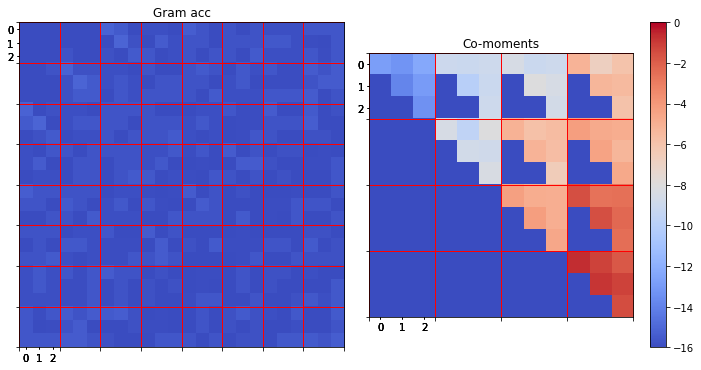

In [23]:
# Straight-forward method
rerr_acc_sum_log, rerr_com_sum_log = np.log10(rerr_acc_sum + 1.0e-32), np.log10(rerr_com_sum + 1.0e-32)
print(np.min(rerr_com_sum_log), np.max(rerr_com_sum_log))
plot_err(rerr_acc_sum_log, rerr_com_sum_log, moment, tr_len, title='', 
         cmap='coolwarm', vmin=-16, vmax=0, fnum=-100)

-32.0 -15.250635064023108


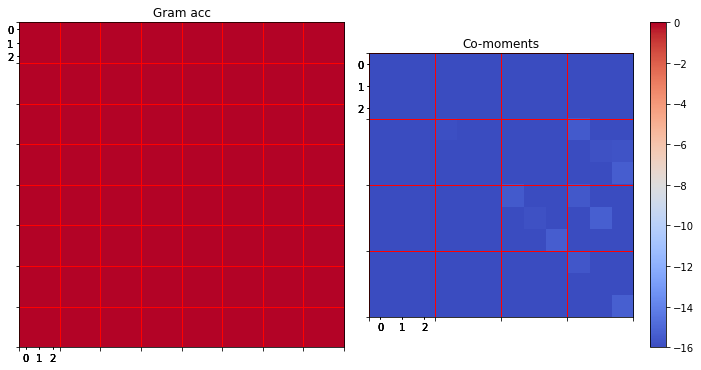

In [24]:
# Detrend method (Gram matrix accumulator is not relevant)
rerr_acc_off_log, rerr_com_off_log = np.log10(rerr_acc_off + 1.0e-32), np.log10(rerr_com_off + 1.0e-32)
print(np.min(rerr_com_off_log), np.max(rerr_com_off_log))
plot_err(rerr_acc_off_log, rerr_com_off_log, moment, tr_len, title='',
         cmap='coolwarm', vmin=-16, vmax=0, fnum=-100)